In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!wget https://github.com/ray-hsiehjy/seizure_recognition/blob/master/README.md

--2019-12-16 17:56:02--  https://github.com/ray-hsiehjy/seizure_recognition/blob/master/README.md
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘README.md’

README.md               [ <=>                ]  62.88K  --.-KB/s    in 0.1s    

2019-12-16 17:56:07 (643 KB/s) - ‘README.md’ saved [64392]



In [0]:
!pip install pyedflib -q

     |████████████████████████████████| 1.1MB 9.2MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from eeg_util_pt2 import get_pickled_data, construct_timesteps

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.backend as K

tf version: 1.15.0
gpu: /device:GPU:0
gpu using cuda: True


In [0]:
# Split subjects into 2 groups, train and test
# np.random.seed(3)
test_size = 4
test_ids = np.random.choice(np.arange(1,25,1), size=test_size, replace=False)
train_ids = [i for i in range(1,25,1) if i not in test_ids]
print(f"test subjects: {test_ids}")

# get data from pickle files
preictal_length = 20
# z_score calculated by individual subject
train_X, train_y = get_pickled_data(train_ids, preictal_length, clean_spectra=True, threshold=-25, z_score=True)
test_X, test_y = get_pickled_data(test_ids, preictal_length, clean_spectra=True, threshold=-25, z_score=True)

for i in range(3):
    print(f"train label {i}: {(train_y==i).sum()}")
for i in range(3):
    print(f"test label {i}: {(test_y==i).sum()}")

test subjects: [ 7 12  4  8]
train label 0: 641465
train label 1: 730
train label 2: 2288
test label 0: 236534
test label 1: 195
test label 2: 691


In [0]:
Tx = 2

# construct_timesteps return [binned_X, binned_y] for given label
train_data = [construct_timesteps(train_X, train_y, label=i, Tx=2, num_interictal=3000) for i in range(3)]
train_X = np.concatenate([lst[0] for lst in train_data], axis=0)
train_y = np.concatenate([lst[1] for lst in train_data], axis=0)

test_data = [construct_timesteps(test_X, test_y, label=i, Tx=2, num_interictal=300) for i in range(3)]
test_X = np.concatenate([lst[0] for lst in test_data], axis=0)
test_y = np.concatenate([lst[1] for lst in test_data], axis=0)

# shuffle segments
np.random.seed(3)
train_order = np.random.permutation(len(train_y))
train_X, train_y = train_X[train_order], train_y[train_order]

np.random.seed(5)
test_order = np.random.permutation(len(test_y))
test_X, test_y = test_X[test_order], test_y[test_order]

for i in range(3):
    print(f"train label {i}: {(train_y==i).sum()}")
for i in range(3):
    print(f"test label {i}: {(test_y==i).sum()}")


train_X.shape, train_y.shape, test_X.shape, test_y.shape

train label 0: 3000
train label 1: 584
train label 2: 2142
test label 0: 300
test label 1: 156
test label 2: 652


((5726, 2, 90), (5726,), (1108, 2, 90), (1108,))

In [0]:
def LSTM_model(Tx: int):
    
    X_input = Input(shape=(Tx, 90))
    X = X_input

    X = Bidirectional(LSTM(128))(X)
    X = BatchNormalization()(X)
    
    X = Dense(128, activation="relu")(X)
    X = BatchNormalization()(X)
    
    output = Dense(3, activation="softmax")(X)

    model = Model(inputs=X_input, outputs=output)
    
    return model
    
    

In [0]:
lstm_clf = LSTM_model(Tx=Tx)
lstm_clf.summary()

train_y_OH = np.eye(3)[train_y]
test_y_OH = np.eye(3)[test_y]

opt=Adam(lr=1e-3)

lr_reduction = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2, 
        patience=5, 
        verbose=1,
        min_delta=1e-4,
        cooldown=0,
        min_lr=1e-6
    )

lstm_clf.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2, 90)]           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               224256    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 259,075
Trainable params: 258,307
Non-trainable params: 768
___________________________________________________

In [0]:
history = lstm_clf.fit(
    train_X,
    train_y_OH,
    validation_data=(test_X, test_y_OH),
    batch_size=16,
    epochs=10,
    # callbacks=[lr_reduction],
    verbose=1
)

Train on 5726 samples, validate on 1108 samples
Epoch 1/10
5726/5726 [==============================] - 5s 898us/sample - loss: 0.5459 - acc: 0.8023 - val_loss: 1.4020 - val_acc: 0.5352
Epoch 2/10
5726/5726 [==============================] - 4s 642us/sample - loss: 0.4257 - acc: 0.8458 - val_loss: 1.7501 - val_acc: 0.4801
Epoch 3/10
5726/5726 [==============================] - 4s 658us/sample - loss: 0.3679 - acc: 0.8589 - val_loss: 2.1267 - val_acc: 0.5325
Epoch 4/10
5726/5726 [==============================] - 4s 653us/sample - loss: 0.3447 - acc: 0.8744 - val_loss: 1.8230 - val_acc: 0.5433
Epoch 5/10
5726/5726 [==============================] - 4s 647us/sample - loss: 0.2927 - acc: 0.8908 - val_loss: 1.9286 - val_acc: 0.5460
Epoch 6/10
5726/5726 [==============================] - 4s 653us/sample - loss: 0.2654 - acc: 0.9020 - val_loss: 1.9422 - val_acc: 0.5090
Epoch 7/10
5726/5726 [==============================] - 4s 650us/sample - loss: 0.2369 - acc: 0.9113 - val_loss: 2.3907 - va

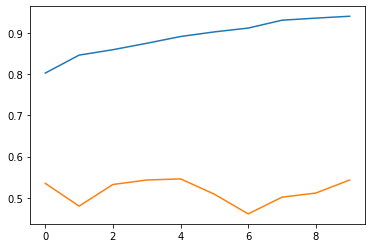

In [0]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])